# CS4487 - Machine Learning
# Lecture 9a - Neural Networks, Deep Learning
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
- History
- Perceptron
- Multi-layer perceptron (MLP)
- Convolutional neural network (CNN)
- Autoencoder (AE)

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

rbow = plt.get_cmap('rainbow')

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Original idea
- _Perceptron_ 
  - Warren McCulloch and Walter Pitts (1943), Rosenblatt (1957)
  - Simulate a neuron in the brain 
    - 1) take binary inputs (input from nearby neurons)
    - 2) multiply by weights (synapses, dendrites)
    - 3) sum and threshold to get binary output (output axon)
  - Train weights from data.
<center><table border=0><tr><td><img src="imgs/neuron.png" width=350></td><td><img src="imgs/neuron_model.jpeg" width=350></tr></table></center>


- Multiple outputs handled by using multiple perceptrons
<center><img src="imgs/multiout.jpg" width=200></center>

- **Problem:**
  - linear classifier, can't solve harder problems

# Multi-layer Perceptron
- Add _hidden_ layers between input and output neurons
  - each layer extracts some features from the previous layers
  - can represent complex non-linear functions 
  - train weights using _backpropagation_ algorithm. (1970-80s)
  - (now called a _neural network_)
<center><table border=0><tr><td><img src="imgs/neural_net.jpeg" width=350></td><td><img src="imgs/neural_net2.jpeg" width=350></tr></table></center>



- **Problem:**
  - difficult to train.
  - sensitive to initialization.
  - computationally expensive (at the time).


# Decline in the 1990s
- Because of those problems, NN became less popular in the 1990s
  - Support vector machines (SVM) had good accuracy
    - easy to use - only one global optimum.
    - learning is not sensitive to initialization.
    - theory about performance guarantees.
  - Not a lot of data, so kernel methods were still okay.

# Deep learning
- There was a resurgence in NN in the 2000s, due to a number of factors:
  - improvements in network architecture
    - developed nodes that are easier to train
  - better training algorithms
    - better ways to prevent overfitting
    - better initialization methods
  - faster computers
    - massively parallel GPUs
  - more labeled data
    - from Internet
    - crowd-sourcing for labeling data (Amazon Turk)    

- We can train NN with more and more layers --> Deep Learning
<center><img src="imgs/bg_pipeline-01.png" width="100%"></center>

In [2]:
def drawplane(w, b=None, c=None, wlabel=None, poscol=None, negcol=None, lw=2, col='k', ls='-', label=None):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # OR
    # w^T (x-c) = 0 = w^Tx - w^Tc  --> b = -w^Tc
    if c is not None:
        b = -sum(w*c)
    
    # the line
    if (abs(w[0])>abs(w[1])):   # vertical line
        x0 = array([-30,30])
        x1 = -w[0]/w[1] * x0 - b / w[1]
    else:                       # horizontal line
        x1 = array([-30,30])
        x0 = -w[1]/w[0] * x1 - b / w[0]
    
    if (poscol) or (negcol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        f = sum(w*[polyx[2], polyy[2]])+b
        if (f>0) and (poscol):
            plt.fill(polyx, polyy, poscol, alpha=0.2)
        if (f<0) and (negcol):
            plt.fill(polyx, polyy, negcol, alpha=0.2)
    
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        f = sum(w*[polyx[2], polyy[2]])+b
        if (f>0) and (poscol):
            plt.fill(polyx, polyy, poscol, alpha=0.2)
        if (f<0) and (negcol):
            plt.fill(polyx, polyy, negcol, alpha=0.2)

    # plot line
    plt.plot(x0, x1, col+ls, lw=lw, label=label)

    # the w
    if (wlabel is not None):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], head_width=0.4,  width=0.01, linestyle=ls, edgecolor=col, facecolor=col)
        plt.text(xpw[0]-0.5, xpw[1], wlabel)

def plot_perceptron(wb, X, Y, axbox, curn=None, wb_old=None):
    if wb_old is None:
        label1 = 'w'
    else:
        label1 = 'new w'
        label2 = 'old w'
    drawplane(wb[0], wb[1], wlabel="", label=label1)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
    if curn is not None:
        plt.plot(X[curn,0], X[curn,1], 'ko', fillstyle='none', markeredgewidth=2, label='selected point')
    if wb_old is not None:
        drawplane(wb_old[0], wb_old[1], lw=1, col='r', ls="--", label=label2)
    plt.grid(True)
    plt.axis(axbox)

In [3]:
# generate random data
X,Y = datasets.samples_generator.make_blobs(n_samples=50, 
         centers=array([[2,5], [-2,-3.2]]), cluster_std=2, n_features=2, 
         random_state=4487)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

lsdatafig = plt.figure()   
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
axbox = [-10,10,-10,10]
plt.axis(axbox); plt.grid(True);
plt.close()

# Outline
- History
- **Perceptron**
- Multi-layer perceptron (MLP)
- Convolutional neural network (CNN)
- Autoencoder (AE)

# Perceptron

- Model a single neuron
  - input $\mathbf{x}\in \mathbb{R}^d$ is a $d$-dim vector
  - apply a weight to the inputs
  - sum and threshold to get the output

- Formally,
  - $y = f( \sum_{j=0}^d w_j x_j) = f(\mathbf{w}^T\mathbf{x})$
  - $\mathbf{w}$ is the weight vector.
  - $f(a)$ is the activation function
    - $f(a) = \begin{cases}1, & a>0 \\ 0, & \text{otherwise}\end{cases}$
<center><img src="imgs/Perceptron.jpg" width=600></center>

# Perceptron training criteria
- Train the perceptron on data $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^N$
- Only look at the points that are misclassified.
  - Loss is based on how badly misclassified
  - $E(\mathbf{w}) = \sum_{i=1}^N \begin{cases} - y_i \mathbf{w}^T \mathbf{x}_i, & \mathbf{x}_i\text{ is misclassified} \\ 0, & \text{otherwise}\end{cases}$
- Minimize the loss: $\mathbf{w}^* = \mathop{\mathrm{argmin}}_{\mathbf{w}} E(\mathbf{w})$

# Training algorithm
- Computers were slow back then...only look at one data point at a time and use gradient descent.
- **Perceptron Algorithm**
  - For each point $\mathbf{x}_i$, 
    - If the point $\mathbf{x}_i$ is misclassified,
      - Update weights: $\mathbf{w} \leftarrow \mathbf{w} + \eta y_i \mathbf{x}_i$
  - Repeat until no more points are misclassified

- **Notes:**
  - $\eta$ is the learning rate for gradient descent
  - The effect of the update step is to rotate $\mathbf{w}$ towards the misclassified point $\mathbf{x}_i$.
  - This is called _Stochastic Gradient Descent_.
    - It is useful because we only need to look at a little bit of data at a time.

In [4]:
def run_perceptron(w_init, X, Y, iterfigs=False):
    w = w_init.copy()
    eta = 1.0

    figs=[]

    for t in range(10):
        # cycle through data points
        haserror = False
        for n in range(len(X)):
            yx = Y[n]*X[n]
            zp = sum(w*yx)
            if (zp<0):
                w_old = w.copy()
                w += eta*yx
                haserror = True
                if iterfigs:
                    figs.append(plt.figure(figsize=(10,4.5)))
                    plt.subplot(1,2,1)
                    plot_perceptron((w_old,0), X, Y, axbox, curn=n)
                    plt.legend(loc='best')
                    plt.subplot(1,2,2)
                    plot_perceptron((w,0), X, Y, axbox, curn=n, wb_old=(w_old,0))
                    plt.legend(loc='best')
                    plt.close()
        print(haserror)
        if not haserror:
            break

    if iterfigs:
        return (w, figs)
    else:
        return w

In [5]:
w,figs = run_perceptron(array([1.0, 0.01]), X, Y, iterfigs=True)

True
True
False


# Example
- Iteration 1
  - $\mathbf{w}$ rotates towards the misclassified point (bold circle)

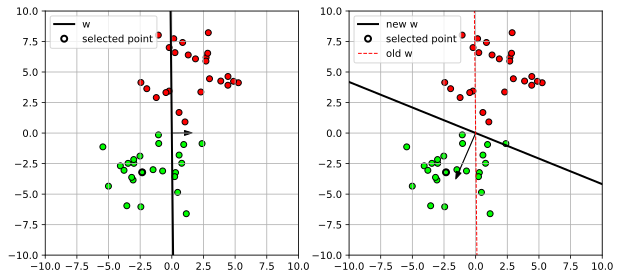

In [6]:
figs[0]

- Iteration 2

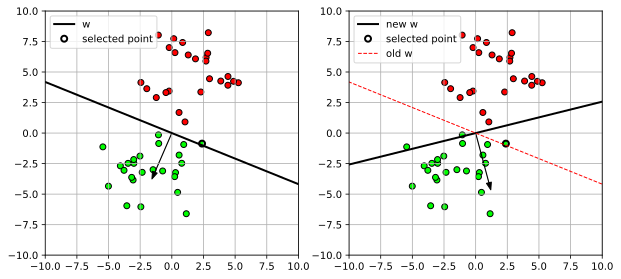

In [7]:
figs[1]

- Iteration 3

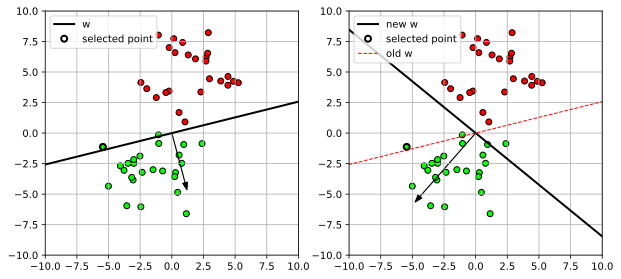

In [8]:
figs[2]

- Iteration 4
  - No more errors

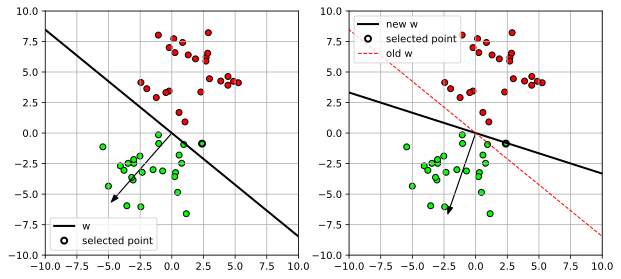

In [9]:
figs[3]

- Final classifier

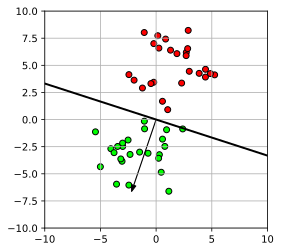

In [10]:
plt.figure(figsize=(4,4))
plot_perceptron((w,0),X,Y,axbox)

# Perceptron Algorithm
- Fails to converge if data is not linearly separable
- Rosenblatt proved that the algorithm will converge if the data is linearly separable.
  - the number of iterations is inversely proportional to the separation (margin) between classes.
  - _This was one of the first machine learning results!_
- Different initializations can yield different weights.

In [11]:
ni = random.permutation(arange(len(X)))
w2 = run_perceptron(array([1.0, 0.01]), X[ni], Y[ni])
ni = random.permutation(arange(len(X)))
w3 = run_perceptron(array([1.0, 0.01]), X[ni], Y[ni])
pfig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plot_perceptron((w,0),X,Y,axbox)
plt.subplot(1,3,2)
plot_perceptron((w2,0),X,Y,axbox)
plt.subplot(1,3,3)
plot_perceptron((w3,0),X,Y,axbox)
plt.close()

True
True
False
True
False


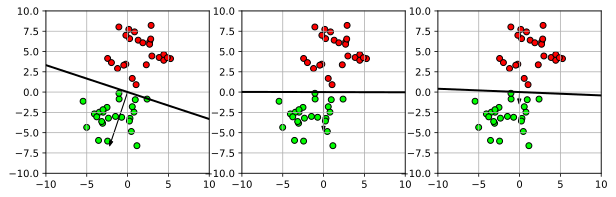

In [12]:
pfig

# Perceptron Loss Function
- Define $z_i = y_i \mathbf{w}^T\mathbf{x}_i$,
- The loss function is $L(z_i) = \max(0,-z_i)$.

In [13]:
z = linspace(-6,6,100)
logloss = log(1+exp(-z)) / log(2)
hingeloss = maximum(0, 1-z)
percloss = maximum(0,-z)
lossfig = plt.figure()

plt.plot([0,0], [0,9], 'k--')
plt.text(0,8.5, "incorrectly classified $\\Leftarrow$ ", ha='right', weight='bold')
plt.text(0,8.5, " $\Rightarrow$ correctly classified", ha='left', weight='bold')

plt.plot(z,hingeloss, 'b-', label='hinge (SVM)')
plt.plot(z,logloss, 'r-', label='logistic (LR)')
plt.plot(z,percloss, 'c-', label='perceptron')
plt.grid(True)
plt.xlabel('$z_i$');
plt.ylabel('loss')
plt.legend(loc='right')
plt.title('loss functions')
plt.close()

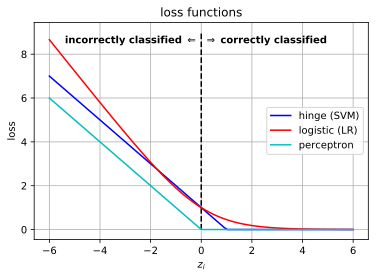

In [14]:
lossfig

# Outline
- History
- Perceptron
- **Multi-layer perceptron (MLP)**
- Convolutional neural network (CNN)
- Autoencoder (AE)

# Multi-layer Perceptron
- Add hidden layers between the inputs and outputs
  - each hidden node is a Perceptron (with its own set of weights)
    - its inputs are the outputs from previous layer
    - extracts a feature pattern from the previous layer
  - can model more complex functions

<center><table border=0><tr><td><img src="imgs/neural_net.jpeg" width=350></td><td><img src="imgs/neural_net2.jpeg" width=350></tr></table></center>

- Formally, for one layer: 
  - $\mathbf{h} = f(\mathbf{W}^T \mathbf{x})$
    - Weight matrix $\mathbf{W}$ - one column for each node
    - Input $\mathbf{x}$ - from previous layer
    - Output $\mathbf{h}$ - to next layer
    - $f(a)$ is the activation function - applied to each dimension to get output

# Activation functions
- There are different types of activation functions:
  - _Sigmoid_ - output [0,1]
  - _Tanh_ - output [-1,1]
  - _Rectifier Linear Unit (ReLU)_ - output [0,$\infty$]


In [15]:
x=linspace(-5,5,200)
fs = {'Sigmoid': lambda x: 1/(1+exp(-x)),
      'Tanh':    lambda x: tanh(x),
      'ReLU':    lambda x: maximum(0,x),
     }

actfig = plt.figure()
for name,f in fs.items():
    plt.plot(x, f(x), label=name)
plt.legend(loc="lower right")
plt.axis([-5,5,-2,2])
plt.grid(True)
plt.close()


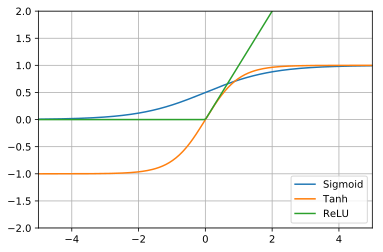

In [16]:
actfig

- Activation functions specifically for output nodes:
  - _Linear_ - output for regression
  - _Softmax_ - output for classification (same as multi-class logistic regression)
  
- Each layer can use a different activation function.

# Which activation function is best?
- In the early days, only the Sigmoid and Tanh activation functions were used.
  - these were notoriously hard to train with.
    - "vanishing gradient" problem
- Recently, ReLU has become very popular.
  - easier to train with - no "vanishing gradient"
  - faster - don't need to calculate exponential
  - sparse representation - most nodes will output zero.
  

# Training an MLP
- For classification, we use the cross-entropy loss
  - $E = -\sum_{j=1}^K y_j \log \hat{y}_j$
    - $y_j$ is 1 for the true class, and 0 otherwise
    - $\hat{y}_j$ is the softmax output for the j-th class
- Use gradient descent as before:
  - $w_{ij} \leftarrow w_{ij} - \eta \frac{dE}{dw_{ij}}$
    - layer $i$, node $j$
  - $\eta$ is the learning rate
    - controls convergence rate
      - too small --> converges very slowly
      - too large --> possibly doesn't converge

# Backpropagation (backward propagation)
- Do a forward pass to calculate the prediction
- Do a backward pass to update weights that were responsible for an error
<center><img src="imgs/BP.png" width="100%"></center>

# Gradient descent with the chain-rule
- Suppose we have a 2-layer network
  - $E$ is the cost function
  - $g_1$, $g_2$ are the output functions of the two layers
    - $g_j(\mathbf{x}) = f(\mathbf{W}_j^T\mathbf{x})$
    - $\mathbf{W}_1$, $\mathbf{W}_2$ are the weight matrices
- Prediction for input $\mathbf{x}$: $y = g_2(g_1(\mathbf{x}))$
- Cost for input $\mathbf{x}$: $E(\mathbf{x}) = E(g_2(g_1(\mathbf{x})))$

- Apply the chain rule to get the gradients of weights in layer
  - $\frac{dE(\mathbf{x})}{d\mathbf{W}_2} = \frac{dE}{dg_2}\frac{dg_2}{d\mathbf{W}_2}$
  - $\frac{dE(\mathbf{x})}{d\mathbf{W}_1} = \frac{dE}{dg_2}\frac{dg_2}{dg_1}\frac{dg_1}{d\mathbf{W}_1}$
- Defines a set of recursive relationships
  - 1) calculate the output of each node from first to last layer
  - 2) calculate the gradient of each node from last to first layer
- NOTE: the gradients multiply in each layer!
  - if two gradients are small (<1), their product will be even smaller.  This is the "vanishing gradient" problem.

# Stochastic Gradient Descent (SGD)
- The datasets needed to train NN are typically very large
- Use SGD so that only a small portion of the dataset is needed at a time
  - Each small portion is called a _mini-batch_
  - Use a _momentum_ term, which averages the current gradient with those from previous mini-batches.
  - One complete pass through the data is called an _epoch_.

# Other Tricks
- Normalize the inputs to [-1,1] or [0,1]
  - improves numerical stability.
- Separate the training set into training and validation
  - use the training set to run backpropagation
  - test the NN on the validation set for diagnostics
    - check for convergence - adjust learning rate if necessary
    - check for diverging loss - adjust learning rate
    - stopping criteria - stop when no change in the validation error.
    - decay learning rate after each epoch.

# Load NN software
- We will use _keras_
  - compatible with scikit-learn
  - keras is an easy-to-use front-end for other (more complicated) NN backends.
    - using Tensorflow backend (could also use Theano)

In [17]:
# use TensorFlow backend
%env KERAS_BACKEND=tensorflow     
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Activation

env: KERAS_BACKEND=tensorflow


D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
keras.__version__

'2.2.4'

In [19]:
tensorflow.__version__

'1.12.0'

In [20]:
# type three - moons
X0,Y = datasets.samples_generator.make_moons(n_samples=100,
                                            noise=0.1, random_state=4487)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
X = scaler.fit_transform(X0)

axbox = [-1.2, 1.2, -1.2, 1.2]

In [21]:
def plot_nn(model, axbox, X, Y, mode="prob"):
    # assumes a sigmoid output node
    # grid points
    xr = [ linspace(axbox[0], axbox[1], 200), 
           linspace(axbox[2], axbox[3], 200) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # calculate the decision function
    if mode == "prob":
        scoreall = model.predict_proba(allpts)
        score = scoreall[:,1].reshape(xgrid0.shape)
        maxscore = 1.0
        minscore = 0.0
        al = 0.3
        
    elif mode == "predict":
        score = model.predict_classes(allpts).reshape(xgrid0.shape)
        maxscore = 1.0
        minscore = 0.0
        al = 0.3

    plt.imshow(score, origin='lower', extent=axbox, alpha=al, cmap=mycmap, 
               vmin=minscore, vmax=maxscore, aspect='auto')

    plt.contour(xr[0], xr[1], score, levels=[0.5], linestyles='solid', colors='k',
                linewidths=2)
    
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
    plt.axis(axbox); plt.grid(True)    

In [22]:
def plot_history(history):    
    plt.plot(history.history['loss'], label="training loss ({:.6f})".format(history.history['loss'][-1]))
    plt.plot(history.history['val_loss'], label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    plt.grid(True)
    plt.legend(loc="best", fontsize=9)
    plt.axis([0,len(history.history['loss']), 0, 0.7])
    plt.xlabel('iteration')
    plt.ylabel('loss')

- train 1 NN with just one output layer
  - this is the same as logistic regression

In [23]:
# initialize random seed
random.seed(4487)
tensorflow.set_random_seed(4487)  # remove if using Theano

# convert class labels to binary indicators (required for Keras)
Yb = keras.utils.np_utils.to_categorical(Y)

# build the network
nn = Sequential()
nn.add(Dense(units=2,             # number of output nodes (classes)
             input_dim=2,         # input dimension
             activation='softmax' # softmax is for classification
            )
      )

In [24]:
# compile the network
nn.compile(loss=keras.losses.categorical_crossentropy,   # classification loss
     optimizer=keras.optimizers.SGD(  # use SGD for optimization
               lr=0.01,       # learning rate
               momentum=0.9,  # momentum for averaging over batches 
               nesterov=True  # use Nestorov momentum
            ))

# fit the network
history = nn.fit(X, Yb,                # the input/output data
                 epochs=100,           # number of iterations
                 batch_size=32,        # batch size
                 validation_split=0.1, # ratio of data for validation
                 verbose=False         # set to True to see each iteration
                )

  - training and validation loss have converged

In [25]:
nnfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_nn(nn, axbox, X, Y)
plt.subplot(1,2,2)
plot_history(history)
plt.close()

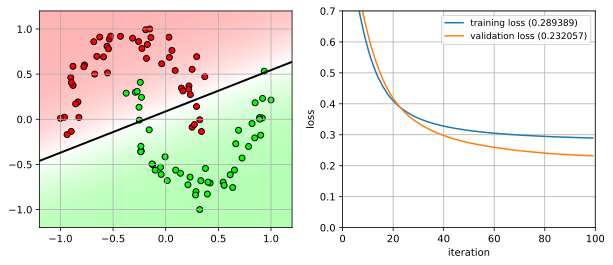

In [26]:
nnfig

- Add one 1 hidden layer with 2 ReLU nodes
  - can carve out part of the red class.

In [27]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=2,             # 2 nodes in the hidden layer
             input_dim=2, 
             activation='relu'))
nn.add(Dense(units=2,             # 2 output nodes (one for each class)
             activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.3, momentum=0.9, nesterov=True))
history = nn.fit(X, Yb, epochs=100, batch_size=32, validation_split=0.1, verbose=False)

In [28]:
nnfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_nn(nn, axbox, X, Y)
plt.subplot(1,2,2)
plot_history(history)
plt.close()

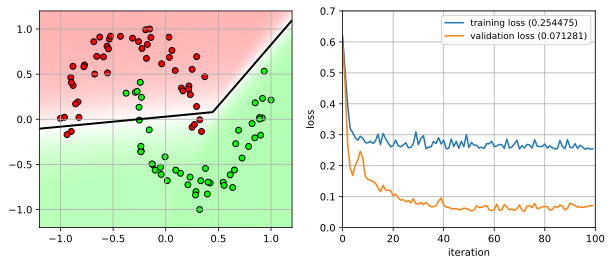

In [29]:
nnfig

- Let's try more nodes
  - 1 hidden layer with 20 hidden nodes
  - with enough nodes, we can get a perfect classifier.

In [30]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=20, input_dim=2, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.SGD(lr=0.3, momentum=0.9, nesterov=True))
history = nn.fit(X, Yb, epochs=100, batch_size=32, validation_split=0.1, verbose=False)

In [31]:
nnfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_nn(nn, axbox, X, Y)
plt.subplot(1,2,2)
plot_history(history)
plt.close()

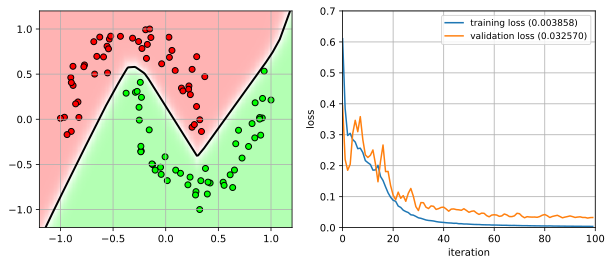

In [32]:
nnfig

# Overfitting
- Continuous training will sometimes lead to overfitting
  - the training loss decreases, but the validation loss increases

In [33]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=2, input_dim=2, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.5, momentum=0.9, nesterov=True))
history = nn.fit(X, Yb, epochs=100, batch_size=32, validation_split=0.1, verbose=False)

In [34]:
nnfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_nn(nn, axbox, X, Y)
plt.subplot(1,2,2)
plot_history(history)
plt.close()

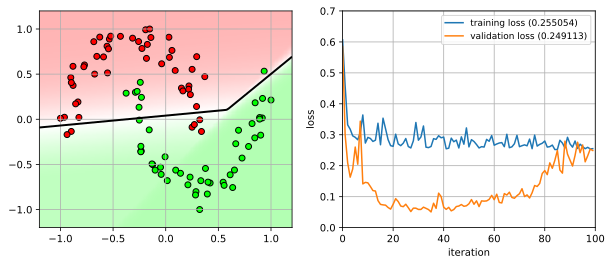

In [35]:
nnfig

# Early stopping

- Training can stopped when the validation loss is stable for a number of iterations
  - stable means change below a threshold
  - this is to prevent overfitting the training data.
  - we can limit the number of iterations.

In [36]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=2, input_dim=2, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

# setup early stopping callback function
earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # look at the validation loss
    min_delta=0.0001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto'
)
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.5, momentum=0.9, nesterov=True))
history = nn.fit(X, Yb, epochs=100, batch_size=32, validation_split=0.1, 
                 verbose=False, 
                 callbacks=callbacks_list)  # setup the callback list

Epoch 00025: early stopping


In [37]:
nnfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_nn(nn, axbox, X, Y)
plt.subplot(1,2,2)
plot_history(history)
plt.close()

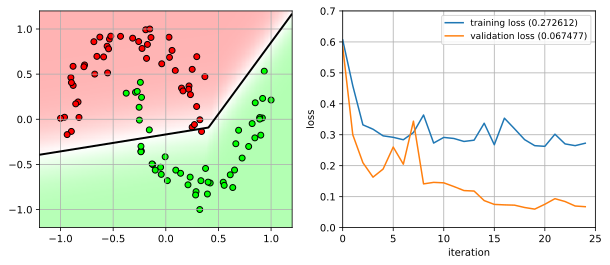

In [38]:
nnfig

# Universal Approximation Theorem
- Cybenko (1989), Hornik (1991)
  - _A multi-layer perceptron with a single hidden layer and a finite number of nodes can approximate any continuous function._
    - The number of nodes needed might be very large.
    - Doesn't say anything about how difficult it is to train it.
- Deep learning corrolary
  - A deep network can learn the same function using less nodes.
  - Given the same number of nodes, a deep network can learn more complex functions.
    - Doesn't say anything about how difficult it is to train it.

# Example
- Network with 1 hidden layer
  - input (2D) -> 40 hidden nodes -> output (2D)

In [39]:
X2 = vstack((X, X+array([1.2,0])))
Y2 = r_[Y, Y]
Y2b = keras.utils.to_categorical(Y2)
axbox2 = [-1.2, 2.5, -1.2, 1.2]

In [40]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# build the network
nn = Sequential()
nn.add(Dense(units=40, input_dim=2, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.4, momentum=0.9, nesterov=True))
history = nn.fit(X2, Y2b, epochs=100, batch_size=32, validation_split=0.1, verbose=False)

In [41]:
nnfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_nn(nn, axbox2, X2, Y2)
plt.subplot(1,2,2)
plot_history(history)
plt.close()

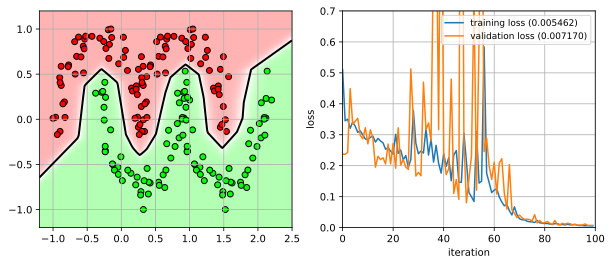

In [42]:
nnfig

In [43]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 40)                120       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 82        
Total params: 202
Trainable params: 202
Non-trainable params: 0
_________________________________________________________________


- 3 hidden layers:
  - input (2D) -> 8 nodes -> 5 nodes -> 3 nodes -> output (2D)

In [44]:
# initialize random seed
random.seed(449); tensorflow.set_random_seed(4488)

# build the network
nn = Sequential()
nn.add(Dense(units=8, input_dim=2, activation='relu'))
nn.add(Dense(units=5, activation='relu'))
nn.add(Dense(units=3, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.07, momentum=0.9, nesterov=True))
history = nn.fit(X2, Y2b, epochs=125, batch_size=32, validation_split=0.1, verbose=False)

In [45]:
nnfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_nn(nn, axbox2, X2, Y2)
plt.subplot(1,2,2)
plot_history(history)
plt.close()

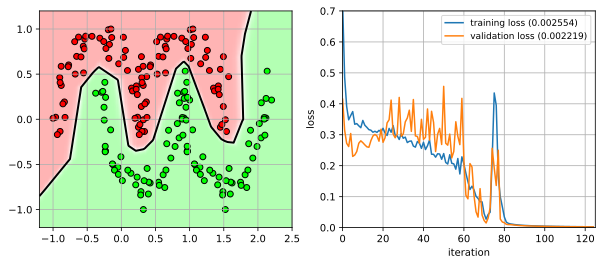

In [46]:
nnfig

In [47]:
nn.summary()
# less parameters, similar classifier.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 45        
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 8         
Total params: 95
Trainable params: 95
Non-trainable params: 0
_________________________________________________________________
